#### Name: Mostafa Ayman Hegazy
#### Email: m.hegazy@innopolis.university

# Machine Learning Final Project.

#### $1^{st}$ Reproducibility Confirmation

In [1]:
import numpy as np
import tensorflow.keras as tf
import tensorflow
import random as rn
import os

os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(1234)
rn.seed(1234)
tensorflow.random.set_seed(1234)

#### $2^{nd}$ Data loading

In [2]:
!wget -nc http://ml_course.gordinmitya.ru/modified_public.zip
!unzip -o modified_public.zip

--2020-12-14 10:35:13--  http://ml_course.gordinmitya.ru/modified_public.zip
Resolving ml_course.gordinmitya.ru (ml_course.gordinmitya.ru)... 94.130.188.64
Connecting to ml_course.gordinmitya.ru (ml_course.gordinmitya.ru)|94.130.188.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174498684 (166M) [application/zip]
Saving to: ‘modified_public.zip’

modified_public.zip 100%[===================>] 166.41M  18.5MB/s    in 10s     

2020-12-14 10:35:24 (16.4 MB/s) - ‘modified_public.zip’ saved [174498684/174498684]

Archive:  modified_public.zip
   creating: modified_public/
  inflating: modified_public/xt_modified.npy  
  inflating: modified_public/xs.npy  
  inflating: modified_public/ys.npy  


In [3]:
xs = np.load('/kaggle/working/modified_public/xs.npy')
ys = np.load('/kaggle/working/modified_public/ys.npy')
xt = np.load('/kaggle/working/modified_public/xt_modified.npy')

print(xs.shape, ys.shape, xt.shape)

(52500, 32, 32, 3) (52500,) (10001, 32, 32, 3)


#### $3^{rd}$ Data visualisation
##### Unlabeled Data

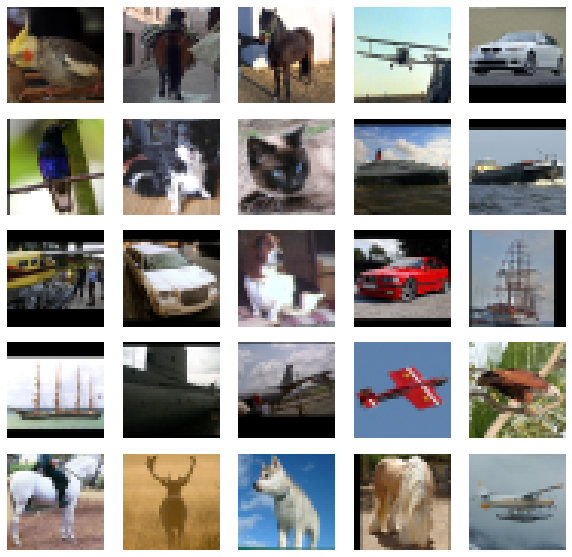

In [4]:
import matplotlib.pyplot as plt
W_grid=5
L_grid=5
fig,axes = plt.subplots(L_grid,W_grid,figsize=(10,10))
axes=axes.ravel()
n_training=len(xt)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) #Pick a random number 
    axes[i].imshow(xt[index])
#     axes[i].set_title(ys[index]) #Prints labels on top of the picture
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.15)

##### Labeled Data

In [ ]:
fig, axs = plt.subplots(9, 9,figsize=(20,20))
count = [0 for i in range(0,9)]

for i in range(0,2000):
      if count[ys[i]] < 9:
        axs[ys[i],count[ys[i]]].imshow(xs[i])
        axs[ys[i],count[ys[i]]].axis('off')  
        axs[ys[i],count[ys[i]]].set_title(ys[i])
        count[ys[i]] = count[(ys[i])]+1
plt.show()        

##### Check if all the classes are equally split

In [ ]:
plt.hist(ys,edgecolor='white', linewidth=1)

#### $4^{th}$ One hot encode labels


In [5]:
x_train = xs
# Encode the classes
y_train = tf.utils.to_categorical(ys)

print(x_train.shape, y_train.shape)

(52500, 32, 32, 3) (52500, 9)


#### $5^{th}$ Define my Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization,\
                                    AveragePooling2D,experimental,Input, GlobalMaxPooling2D
from tensorflow.keras.layers import Lambda, Activation, concatenate
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.applications import efficientnet

base_model = efficientnet.EfficientNetB2(include_top=False, weights='imagenet', input_shape=(260,260,3)\
                                         ,classes=y_train.shape[1], drop_connect_rate = 0.25)

base_model.trainable = False

def make_fet_ext():
    conv_input = Input(shape=(32, 32, 3), name="original_img")
    x = Resizing(260,260)(conv_input)
    conv_output = base_model(x)
    conv = tf.Model(conv_input, conv_output)
    conv.summary()
    return conv

def make_clf():
  clf_input = Input(shape=(9, 9, 1408), name="clf_inp")
  x = tf.layers.Flatten()(clf_input)
  x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.35)(x)
  x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.45)(x)
  clf_output = Dense(9, activation='softmax')(x)
  clf = tf.Model(clf_input, clf_output)
  clf.summary()
  return clf

def make_model(conv, clf):
    Model_input = Input(shape=(32, 32, 3))
    conv_img = conv(Model_input)
    clf_img = clf(conv_img)
    return tf.Model(Model_input, clf_img)

31793152/31790344 [==============================] - 0s 0us/step


#### $8^{th}$ Make the model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 260, 260, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 9, 9, 1408)        7768569   
Total params: 7,768,569
Trainable params: 0
Non-trainable params: 7,768,569
_________________________________________________________________
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
clf_inp (InputLayer)         [(None, 9, 9, 1408)]      0         
_________________________________________________________________
flatten (Flatten)            (None, 114048)            0         
______________________

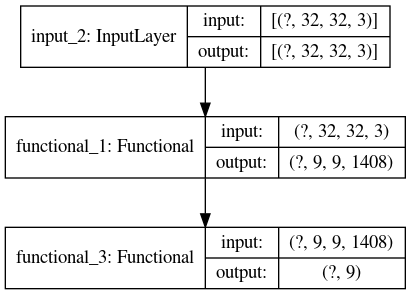

In [7]:
from tensorflow.keras.utils import plot_model

model = make_model(make_fet_ext(),make_clf())
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='EfficientNetB2.png')

##### $9^{th}$ Compile the model & Define the optimizer

In [8]:
opt = tf.optimizers.Adam(learning_rate=0.001)

##### $10^{th}$ Declare the callbacks

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience= 7, restore_best_weights = True)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, factor = 0.333)

##### $11^{th}$ Train the classifier model

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(model, X, Y, opt, epochs=30, compile=True):
    if compile:
        model.compile(optimizer=opt, metrics=['accuracy'],\
                    loss='categorical_crossentropy')
        
    gen = ImageDataGenerator(rotation_range=20, height_shift_range=0.1,\
                                width_shift_range=0.1, horizontal_flip=True, validation_split = 0.15)
    
    batch_size = 64
    steps = int(X.shape[0] / batch_size)
    
    history = model.fit(gen.flow(X, Y, batch_size = batch_size),steps_per_epoch = steps, epochs= epochs, \
                        validation_data= gen.flow(X, Y, batch_size= batch_size, subset = 'validation'),\
                        shuffle=True, callbacks = [early_stopping, lr_scheduler], verbose=1)
    
    diagnostics(history)
    return

def test_model(model, x_test, y_test):
    # evaluate model
    _, acc = model.evaluate(x_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))
    return

def diagnostics(history):
    fig, axs = plt.subplots(2, 1,figsize=(10,7.5))
    titles = ['Cross Entropy Loss', 'Classification Accuracy']
    tags = [['loss','val_loss'],['accuracy','val_accuracy']]
    for i,ax in enumerate(axs):
        ax.set_title(titles[i])
        ax.plot(history.history[tags[i][0]], color='blue', label='train')
        ax.plot(history.history[tags[i][1]], color='orange', label='test')
    filename = 'Train_test_dropout'
    plt.savefig(filename + '_plot.png')
    plt.show()        

Epoch 1/10
820/820 [==============================] - 146s 179ms/step - loss: 0.7854 - accuracy: 0.7346 - val_loss: 0.2985 - val_accuracy: 0.8968
Epoch 2/10
820/820 [==============================] - 143s 175ms/step - loss: 0.5487 - accuracy: 0.8114 - val_loss: 0.2627 - val_accuracy: 0.9072
Epoch 3/10
820/820 [==============================] - 143s 175ms/step - loss: 0.5006 - accuracy: 0.8288 - val_loss: 0.2511 - val_accuracy: 0.9161
Epoch 4/10
820/820 [==============================] - 143s 175ms/step - loss: 0.4772 - accuracy: 0.8381 - val_loss: 0.2275 - val_accuracy: 0.9201
Epoch 5/10
820/820 [==============================] - 143s 174ms/step - loss: 0.4538 - accuracy: 0.8447 - val_loss: 0.2232 - val_accuracy: 0.9255
Epoch 6/10
820/820 [==============================] - 143s 175ms/step - loss: 0.4425 - accuracy: 0.8482 - val_loss: 0.2016 - val_accuracy: 0.9276
Epoch 7/10
820/820 [==============================] - 142s 174ms/step - loss: 0.4350 - accuracy: 0.8525 - val_loss: 0.2136 -

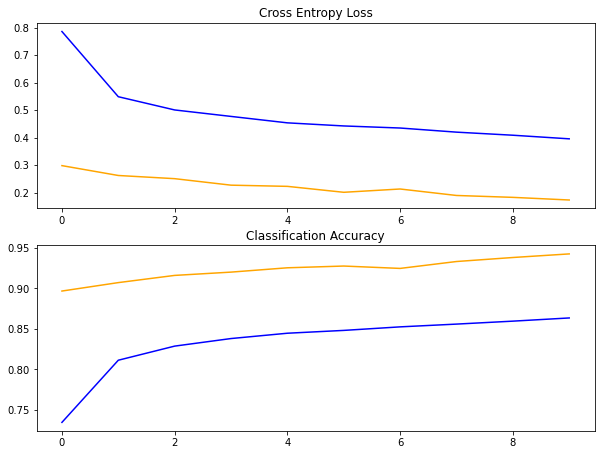

In [11]:
train_model(model, x_train, y_train, opt, epochs=10, compile=True)

In [16]:
model.save_weights('eff2_weights_1.h5')

#### $12^{th}$ Fine tuning the base model

##### Try to increase the data for training

In [17]:
# Try to increase the data by repeating and augmentation
x_train_rep = np.repeat(x_train, 2, axis=0)
y_train_rep = np.repeat(y_train, 2, axis=0)


##### Fine tune the base model

In [18]:
model.layers[1].layers[2].trainable = True
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 9, 9, 1408)        7768569   
_________________________________________________________________
functional_3 (Functional)    (None, 9)                 58562057  
Total params: 66,330,626
Trainable params: 66,261,259
Non-trainable params: 69,367
_________________________________________________________________


##### Freeze the first 6 blocks and fine tune the 7th block only

In [19]:
for layer in model.layers[1].layers[2].layers[0:-31]:
  layer.trainable = False

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 9, 9, 1408)        7768569   
_________________________________________________________________
functional_3 (Functional)    (None, 9)                 58562057  
Total params: 66,330,626
Trainable params: 61,794,517
Non-trainable params: 4,536,109
_________________________________________________________________


Epoch 1/22
820/820 [==============================] - 165s 201ms/step - loss: 0.3573 - accuracy: 0.8812 - val_loss: 0.1415 - val_accuracy: 0.9539
Epoch 2/22
820/820 [==============================] - 163s 199ms/step - loss: 0.3089 - accuracy: 0.8968 - val_loss: 0.1331 - val_accuracy: 0.9575
Epoch 3/22
820/820 [==============================] - 163s 199ms/step - loss: 0.2832 - accuracy: 0.9061 - val_loss: 0.0999 - val_accuracy: 0.9688
Epoch 4/22
820/820 [==============================] - 163s 199ms/step - loss: 0.2529 - accuracy: 0.9164 - val_loss: 0.0817 - val_accuracy: 0.9726
Epoch 5/22
820/820 [==============================] - 163s 199ms/step - loss: 0.2337 - accuracy: 0.9222 - val_loss: 0.0770 - val_accuracy: 0.9757
Epoch 6/22
820/820 [==============================] - 162s 198ms/step - loss: 0.2235 - accuracy: 0.9263 - val_loss: 0.0774 - val_accuracy: 0.9741
Epoch 7/22
820/820 [==============================] - 162s 198ms/step - loss: 0.2062 - accuracy: 0.9308 - val_loss: 0.0630 -

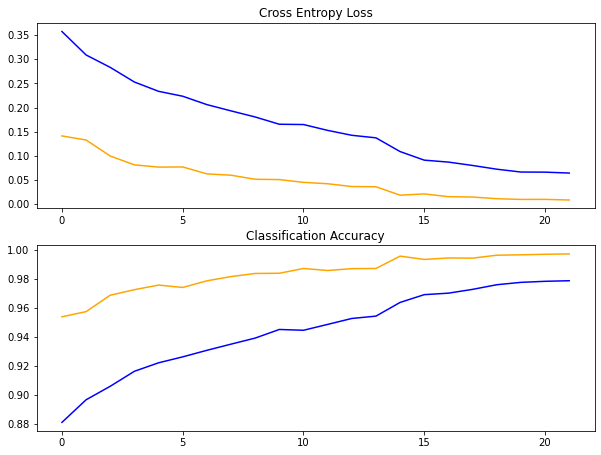

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.001)

train_model(model, x_train, y_train, opt, epochs=22, compile=False)

#### $13^{th}$ Save the fine-tuned model

In [21]:
model.save('eff2_final_1.h5')

#### $14^{th}$ Pseudo Labels

##### Declare the confidence

In [22]:
CONFIDENCE=0.999
xt_train = xt

##### Get pseudo labels function

In [23]:
from sklearn.utils import shuffle

def get_pseudo_labels(model):
    yt_train_prob = model.predict(xt_train)
    labels = np.argmax(yt_train_prob, axis=1)
    prob_max = np.max(yt_train_prob, axis=1)
    yt_train = labels[...,np.newaxis]
    mask = prob_max > CONFIDENCE
    xt_confident = xt_train[mask]
    xt_confident = np.repeat(xt_confident,4, axis=0)
    yt_confident = yt_train[mask]
    yt_confident = np.repeat(yt_confident,4)
    yt_confident = tf.utils.to_categorical(yt_confident)
    
    x_shuff, y_shuff  = shuffle(xt_confident, yt_confident, random_state=123)
    
    return x_shuff, y_shuff

##### Train the model on the new domain

344/344 [==============================] - 70s 203ms/step - loss: 0.0868 - accuracy: 0.9739 - val_loss: 0.0210 - val_accuracy: 0.9931
Epoch 2/10
344/344 [==============================] - 69s 200ms/step - loss: 0.0558 - accuracy: 0.9833 - val_loss: 0.0115 - val_accuracy: 0.9964
Epoch 3/10
344/344 [==============================] - 68s 199ms/step - loss: 0.0474 - accuracy: 0.9850 - val_loss: 0.0147 - val_accuracy: 0.9958
Epoch 4/10
344/344 [==============================] - 68s 199ms/step - loss: 0.0397 - accuracy: 0.9877 - val_loss: 0.0099 - val_accuracy: 0.9970
Epoch 5/10
344/344 [==============================] - 68s 198ms/step - loss: 0.0338 - accuracy: 0.9892 - val_loss: 0.0093 - val_accuracy: 0.9970
Epoch 6/10
344/344 [==============================] - 69s 199ms/step - loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.0061 - val_accuracy: 0.9982
Epoch 7/10
344/344 [==============================] - 69s 200ms/step - loss: 0.0285 - accuracy: 0.9903 - val_loss: 0.0052 - val_accuracy: 0.9

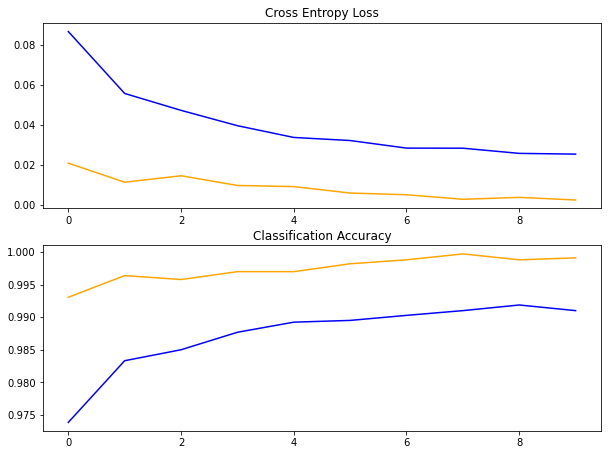

In [24]:
opt = tf.optimizers.Adam(learning_rate=0.001)

x_ps, y_ps = get_pseudo_labels(model)
print(f"{y_ps.shape[0]} samples from target set with confidence>{CONFIDENCE*100}%\n")


train_model(model, x_ps, y_ps, opt, epochs=10, compile=False)

In [25]:
x_ps, y_ps = get_pseudo_labels(model)
print(f"{y_ps.shape[0]} samples from target set with confidence>{CONFIDENCE*100}%\n")


26340 samples from target set with confidence>99.9%



##### Save the final model

In [28]:
model.save('eff2_final_2.h5')

##### Test the correctness of predictions

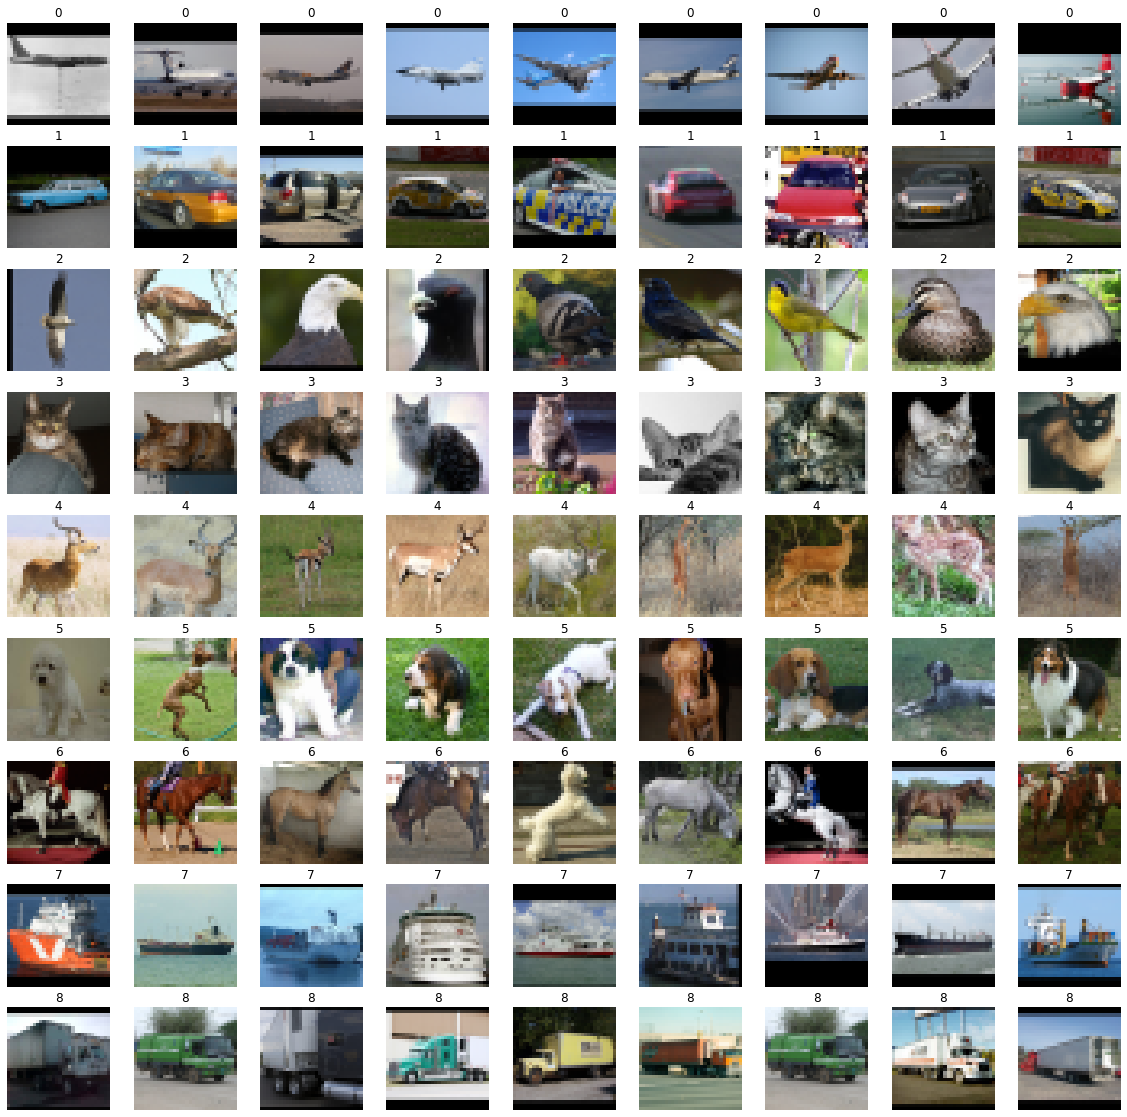

In [29]:
fig, axs = plt.subplots(9, 9,figsize=(20,20))
count = [0 for i in range(0,9)]
y = np.argmax(y_ps, axis=1)
for i in range(10000,14000):
      if count[y[i]] < 9:
        axs[y[i],count[y[i]]].imshow(x_ps[i])
        axs[y[i],count[y[i]]].axis('off')  
        axs[y[i],count[y[i]]].set_title(y[i])
        count[y[i]] = count[(y[i])]+1
plt.show()        

(array([4212., 3388., 1564.,  636.,    0., 1940., 3708., 2700., 2584.,
        1340.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

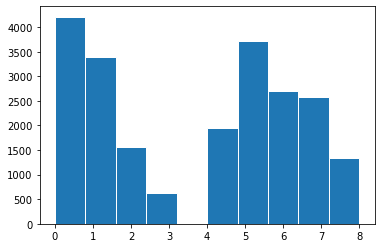

In [30]:
plt.hist(y,edgecolor='white', linewidth=1)